In [1]:
import cdsapi

dataset = "reanalysis-era5-pressure-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "u_component_of_wind",
        "v_component_of_wind"
    ],
    "pressure_level": ["500", "800", "1000"],
    "year": ["2010"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-09-10 10:01:44,244 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-10 10:01:44,418 INFO Request ID is 42a4f422-d144-4fe2-9805-c6a98241cee4
2025-09-10 10:01:44,491 INFO status has been updated to accepted
2025-09-10 10:01:53,076 INFO status has been updated to running
2025-09-10 10:01:58,205 INFO status has been updated to successful


8176c14c59fd8dc32a74a89b926cb7fd.nc:   0%|          | 0.00/124M [00:00<?, ?B/s]

'8176c14c59fd8dc32a74a89b926cb7fd.nc'

In [ ]:
from netCDF4 import Dataset
nc_file = '..8176c14c59fd8dc32a74a89b926cb7fd.nc'
dataset = Dataset(nc_file, mode="r")
print("Variables:", dataset.variables.keys())

Variables: dict_keys(['number', 'valid_time', 'pressure_level', 'latitude', 'longitude', 'expver', 'u', 'v'])


In [3]:
# Load coordinate arrays
lat = dataset.variables["latitude"][:]      # shape (721,)
lon = dataset.variables["longitude"][:]     # shape (1440,)

# Load wind components (eastward and northward)
# Dimensions: (valid_time=12, pressure_level=3, latitude=721, longitude=1440)
u = dataset.variables["u"][:]   # eastward wind
v = dataset.variables["v"][:]   # northward wind

In [4]:
lat.shape, lon.shape, u.shape, v.shape

((721,), (1440,), (12, 3, 721, 1440), (12, 3, 721, 1440))

In [5]:
# create a long-lat gird, with values being the u, v wind components
import numpy as np
lon_grid, lat_grid = np.meshgrid(lon, lat)
u_500 = u[0, 0, :, :]  # shape (721, 1440)
v_500 = v[0, 0, :, :]  # shape (721, 1440)

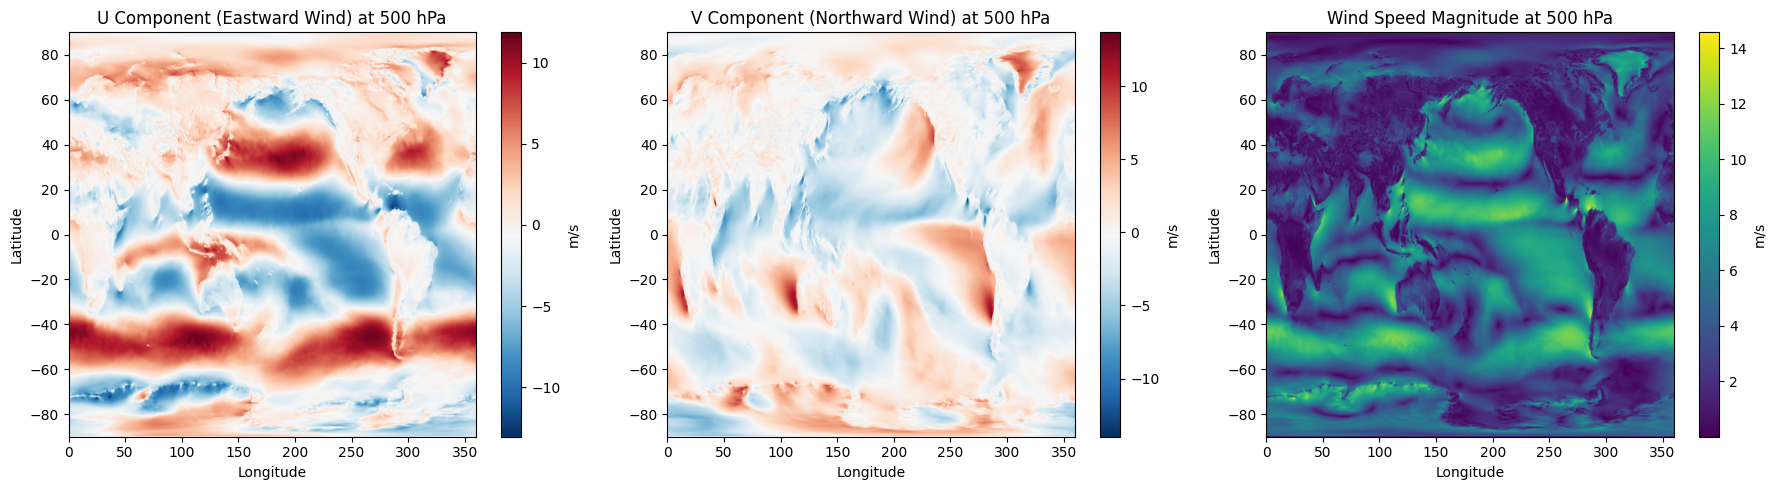

In [6]:
# Calculate wind speed magnitude
wind_speed_500 = np.sqrt(u_500**2 + v_500**2)

# Create a visualization of the wind data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot u component
im1 = axes[0].imshow(u_500, extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
                     cmap='RdBu_r', aspect='auto')
axes[0].set_title('U Component (Eastward Wind) at 500 hPa')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0], label='m/s')

# Plot v component
im2 = axes[1].imshow(v_500, extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
                     cmap='RdBu_r', aspect='auto')
axes[1].set_title('V Component (Northward Wind) at 500 hPa')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[1], label='m/s')

# Plot wind speed magnitude
im3 = axes[2].imshow(wind_speed_500, extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
                     cmap='viridis', aspect='auto')
axes[2].set_title('Wind Speed Magnitude at 500 hPa')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
plt.colorbar(im3, ax=axes[2], label='m/s')

plt.tight_layout()
plt.show()

# Save the processed data
np.savez('wind_data_500hPa.npz', 
         lon=lon, lat=lat, 
         lon_grid=lon_grid, lat_grid=lat_grid,
         u=u_500, v=v_500, wind_speed=wind_speed_500)

In [7]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from skyfield.api import load, EarthSatellite, wgs84, utc

# ----------------------------
# Step 1: Define Aeolus TLE (example from repo)
# ----------------------------
line1 = "1 43600U 18066A   21153.73585495  .00031128  00000-0  12124-3 0  9990"
line2 = "2 43600  96.7150 160.8035 0006915  90.4181 269.7884 15.87015039160910"

ts = load.timescale()
aeolus = EarthSatellite(line1, line2, "AEOLUS", ts)

# ----------------------------
# Step 2: Generate times (every minute for 24h starting Jan 1, 2019 09:00 UTC)
# ----------------------------
start = datetime(2019, 1, 1, 9, tzinfo=utc)
stop = start + timedelta(hours=24)
step = timedelta(minutes=1)

times = []
t = start
while t <= stop:
    times.append(t)
    t += step

# ----------------------------
# Step 3: Propagate orbit to get lat/lon
# ----------------------------
geocentric = aeolus.at(ts.from_datetimes(times))
lat, lon = wgs84.latlon_of(geocentric)

# Convert to arrays in degrees
lat = lat.degrees
lon = lon.degrees % 360  # wrap to [0,360)

raw_track = pd.DataFrame({"time": times, "lat": lat, "lon": lon})

# ----------------------------
# Step 4: Snap to ERA5 grid (721×1440 at 0.25° resolution)
# ----------------------------
era5_lat = np.linspace(90, -90, 721)       # descending order
era5_lon = np.linspace(0, 359.75, 1440)    # 0.25° spacing

def snap_to_grid(lat_val, lon_val):
    i = np.abs(era5_lat - lat_val).argmin()
    j = np.abs(era5_lon - lon_val).argmin()
    return era5_lat[i], era5_lon[j]

snapped = [snap_to_grid(phi, lam) for phi, lam in zip(lat, lon)]
snap_lat, snap_lon = zip(*snapped)

snapped_track = pd.DataFrame({"time": times, "lat": snap_lat, "lon": snap_lon})

# ----------------------------
# Example outputs
# ----------------------------
print("Raw track sample:\n", raw_track.head())
print("Snapped track sample:\n", snapped_track.head())


Raw track sample:
                        time        lat         lon
0 2019-01-01 09:00:00+00:00  38.799453  165.145970
1 2019-01-01 09:01:00+00:00  43.290230  163.965622
2 2019-01-01 09:02:00+00:00  47.767775  162.637952
3 2019-01-01 09:03:00+00:00  52.228839  161.108544
4 2019-01-01 09:04:00+00:00  56.668617  159.295027
Snapped track sample:
                        time    lat     lon
0 2019-01-01 09:00:00+00:00  38.75  165.25
1 2019-01-01 09:01:00+00:00  43.25  164.00
2 2019-01-01 09:02:00+00:00  47.75  162.75
3 2019-01-01 09:03:00+00:00  52.25  161.00
4 2019-01-01 09:04:00+00:00  56.75  159.25


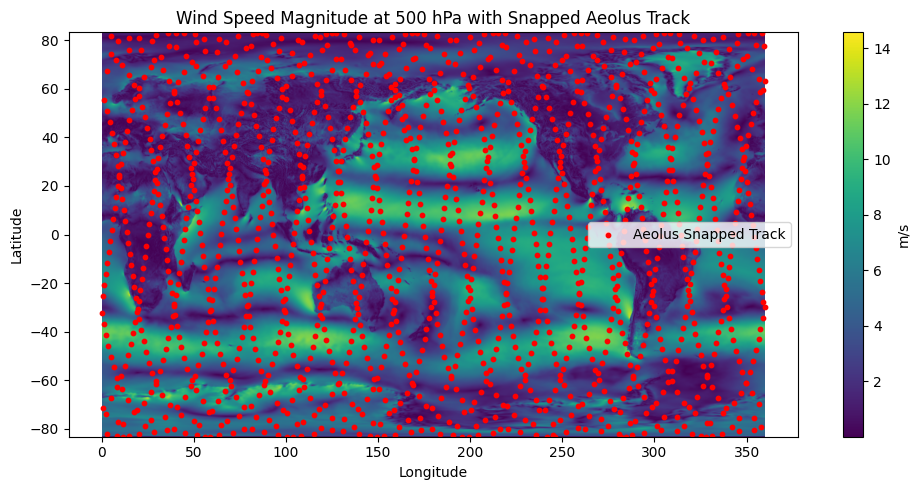

In [8]:
# Compute wind speed magnitude
wind_speed_500 = np.sqrt(u_500**2 + v_500**2)

# Plot the wind speed field
plt.figure(figsize=(10, 5))
im = plt.imshow(
    wind_speed_500,
    extent=[lon.min(), lon.max(), lat.min(), lat.max()],
    cmap="viridis",
    aspect="auto",
    origin="upper",  # because lat is descending
)
plt.colorbar(im, label="m/s")
plt.title("Wind Speed Magnitude at 500 hPa with Snapped Aeolus Track")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Overlay snapped Aeolus points
plt.scatter(
    snapped_track["lon"],
    snapped_track["lat"],
    c="red",
    s=10,
    marker="o",
    label="Aeolus Snapped Track",
)
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
import numpy as np
import networkx as nx
from scipy import sparse

# ----------------------------
# Utilities
# ----------------------------
def deg2rad(x):
    return np.deg2rad(x)

def sph2cart(lat_deg, lon_deg, r=1.0):
    """
    Convert geographic coords (degrees) to 3D unit-sphere (x,y,z).
    lat: [-90, +90], lon: [0, 360) or [-180,180)
    """
    lat = deg2rad(lat_deg)
    lon = deg2rad(lon_deg)
    x = r * np.cos(lat) * np.cos(lon)
    y = r * np.cos(lat) * np.sin(lon)
    z = r * np.sin(lat)
    return np.stack([x, y, z], axis=-1)

def great_circle_distance(lat1_deg, lon1_deg, lat2_deg, lon2_deg, R=1.0):
    """
    Great-circle distance using the haversine formula (on sphere radius R).
    Returns distance on the sphere surface (arc length).
    """
    lat1, lon1 = deg2rad(lat1_deg), deg2rad(lon1_deg)
    lat2, lon2 = deg2rad(lat2_deg), deg2rad(lon2_deg)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    return R * c

def grid_index(i, j, n_lat, n_lon):
    """Flatten (i,j) -> node id."""
    return i * n_lon + j

def inverse_grid_index(node_id, n_lat, n_lon):
    """Unflatten node id -> (i,j)."""
    i = node_id // n_lon
    j = node_id % n_lon
    return i, j

# ----------------------------
# Graph builder
# ----------------------------
def build_sphere_grid_graph(lat, lon, connectivity=4, weight="geodesic", radius=1.0):
    """
    Build a mesh-graph over a regular lat-lon grid on the sphere.

    Parameters
    ----------
    lat : (N_lat,) array (e.g., 721 from +90 to -90)
    lon : (N_lon,) array (e.g., 1440 from 0 to 359.75)
    connectivity : 4 or 8
        4-neighbour: north/south/east/west with periodic wrap in longitude
        8-neighbour: also connect diagonals
    weight : "geodesic" or None
        If "geodesic", weights are great-circle distances (arc length on sphere radius).
        If None, use unweighted edges.
    radius : float
        Sphere radius; 1.0 for unit sphere.

    Returns
    -------
    G : networkx.Graph
        Nodes [0..N_lat*N_lon-1] with attributes:
          - lat, lon (degrees)
          - xyz: (x,y,z) on unit sphere
    A : scipy.sparse.csr_matrix
        Weighted adjacency (symmetric).
    """
    n_lat = len(lat)
    n_lon = len(lon)

    # Precompute per-node attributes
    Lon_grid, Lat_grid = np.meshgrid(lon, lat)  # shapes (n_lat, n_lon)
    xyz = sph2cart(Lat_grid.ravel(), Lon_grid.ravel(), r=1.0)

    # Build edges
    rows = []
    cols = []
    data = []

    # neighbor offsets (diagonals optional)
    nbrs_4 = [(0, 1), (0, -1), (1, 0), (-1, 0)]          # E, W, S, N (i is lat index; note lat usually descending)
    nbrs_8 = nbrs_4 + [(1, 1), (1, -1), (-1, 1), (-1, -1)]
    nbrs = nbrs_8 if connectivity == 8 else nbrs_4

    for i in range(n_lat):
        for j in range(n_lon):
            nid = grid_index(i, j, n_lat, n_lon)
            for di, dj in nbrs:
                ii = i + di
                jj = (j + dj) % n_lon  # periodic in longitude
                if 0 <= ii < n_lat:
                    nid2 = grid_index(ii, jj, n_lat, n_lon)

                    if weight == "geodesic":
                        w = great_circle_distance(lat[i], lon[j], lat[ii], lon[jj], R=radius)
                    else:
                        w = 1.0

                    rows.append(nid)
                    cols.append(nid2)
                    data.append(w)

    # Symmetric adjacency
    A = sparse.coo_matrix((data, (rows, cols)), shape=(n_lat*n_lon, n_lat*n_lon))
    # Make explicitly symmetric (since we added both directions for E/W etc., this is safe)
    A = ((A + A.T) * 0.5).tocsr()

    # Build networkx graph from adjacency
    G = nx.from_scipy_sparse_array(A)
    # Attach node attributes
    node_attrs = {}
    for nid in range(n_lat * n_lon):
        i, j = inverse_grid_index(nid, n_lat, n_lon)
        node_attrs[nid] = {
            "lat": float(lat[i]),
            "lon": float(lon[j]),
            "xyz": tuple(xyz[nid]),
        }
    nx.set_node_attributes(G, node_attrs)

    return G, A

# ----------------------------
# Snapping helpers
# ----------------------------
def nearest_node_indices_for_track(track_lat, track_lon, lat, lon):
    """
    Given a track of points (lat, lon), return nearest grid (i,j) for each.
    Works for ERA5-style regular grid.

    Returns
    -------
    idx_ij : array of shape (N, 2) with int (i, j) indices.
    node_ids : array of shape (N,) flattened node ids.
    """
    # ERA5 latitude is often descending (90 -> -90); lon is uniform [0, 360)
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    track_lat = np.asarray(track_lat)
    track_lon = np.asarray(track_lon) % 360.0

    # nearest indices by absolute difference (fast for regular grid)
    i_idx = np.abs(track_lat[:, None] - lat[None, :]).argmin(axis=1)
    # Note: if your lon is [-180,180), normalize both to same frame first.
    j_idx = np.abs(track_lon[:, None] - lon[None, :]).argmin(axis=1)

    node_ids = i_idx * len(lon) + j_idx
    idx_ij = np.stack([i_idx, j_idx], axis=1)
    return idx_ij, node_ids


In [10]:
# Suppose these come from your file:

lat = dataset.variables["latitude"][:]
lon = dataset.variables["longitude"][:]
G, A = build_sphere_grid_graph(lat, lon, connectivity=4, weight="geodesic", radius=1.0)

# If you have a snapped Aeolus track dataframe with columns ["lat","lon"]:
# snapped_track: DataFrame from your previous step
idx_ij, node_ids = nearest_node_indices_for_track(
    track_lat=snapped_track["lat"].values,
    track_lon=snapped_track["lon"].values,
    lat=lat, lon=lon,
)

# Example: pull those nodes' 3D coordinates to plot on a sphere later
xyz_track = np.array([G.nodes[n]["xyz"] for n in node_ids])

print(f"Graph statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Adjacency matrix shape: {A.shape}")
print(f"Number of Aeolus track points: {len(node_ids)}")
print(f"Unique track nodes: {len(np.unique(node_ids))}")

Graph statistics:
Number of nodes: 1038240
Number of edges: 2075040
Adjacency matrix shape: (1038240, 1038240)
Number of Aeolus track points: 1441
Unique track nodes: 1441


In [11]:
# =============================================================================
# FINAL DATA PREPARATION FOR MACHINE LEARNING
# =============================================================================

print("Preparing final datasets for training...")

# 1. Load the processed wind data
wind_data = np.load('wind_data_500hPa.npz')
lat_grid = wind_data['lat']
lon_grid = wind_data['lon'] 
u_component = wind_data['u']      # shape (721, 1440)
v_component = wind_data['v']      # shape (721, 1440)

# 2. Create adjacency matrix A (already computed above as sparse CSR)
A = A.tocsr()  # Ensure CSR format
print(f"Adjacency matrix A shape: {A.shape}, format: {A.format}")

# 3. Create node coordinate matrix X (all grid points)
# Each node has (lat, lon) coordinates
n_lat, n_lon = len(lat_grid), len(lon_grid)
X = np.zeros((n_lat * n_lon, 2))

for i in range(n_lat):
    for j in range(n_lon):
        node_id = i * n_lon + j
        X[node_id, 0] = lat_grid[i]  # latitude
        X[node_id, 1] = lon_grid[j]  # longitude

print(f"Node coordinates X shape: {X.shape}")

# 4. Create output matrix y (u,v components stacked)
# Flatten spatial dimensions and stack u,v components
u_flat = u_component.flatten()  # shape (721*1440,)
v_flat = v_component.flatten()  # shape (721*1440,)
y = np.column_stack([u_flat, v_flat])  # shape (721*1440, 2)

print(f"Output matrix y shape: {y.shape}")

# 5. Create training locations X_train (Aeolus satellite track coordinates)
# Get unique node indices from the Aeolus track
unique_train_nodes = np.unique(node_ids)
X_train_indices = unique_train_nodes
X_train = X[X_train_indices]  # coordinates of training points
y_train = y[X_train_indices]  # corresponding wind measurements

print(f"Training coordinates X_train shape: {X_train.shape}")
print(f"Training outputs y_train shape: {y_train.shape}")
print(f"Training node indices shape: {X_train_indices.shape}")

# 6. Summary of final datasets
print("\n" + "="*60)
print("FINAL DATASET SUMMARY")
print("="*60)
print(f"A (adjacency matrix):     {A.shape} sparse CSR")
print(f"X (all node coordinates): {X.shape} - (lat, lon) for each grid point")
print(f"y (all outputs):          {y.shape} - (u, v) wind components")
print(f"X_train (training coords): {X_train.shape} - Aeolus track coordinates")
print(f"y_train (training outputs): {y_train.shape} - Wind at Aeolus locations")
print(f"X_train_indices:          {X_train_indices.shape} - Node indices for training")

# 7. Save the prepared datasets
np.savez('wind_data_processed_500hPa.npz',
         A_data=A.data,
         A_indices=A.indices, 
         A_indptr=A.indptr,
         A_shape=A.shape,
         X=X,
         y=y,
         X_train=X_train,
         y_train=y_train,
         X_train_indices=X_train_indices)

print(f"\nAll datasets saved to 'wind_data_processed_500hPa.npz'")
print("Use scipy.sparse.csr_matrix((data, indices, indptr), shape) to reconstruct A")

Preparing final datasets for training...
Adjacency matrix A shape: (1038240, 1038240), format: csr
Node coordinates X shape: (1038240, 2)
Output matrix y shape: (1038240, 2)
Training coordinates X_train shape: (1441, 2)
Training outputs y_train shape: (1441, 2)
Training node indices shape: (1441,)

FINAL DATASET SUMMARY
A (adjacency matrix):     (1038240, 1038240) sparse CSR
X (all node coordinates): (1038240, 2) - (lat, lon) for each grid point
y (all outputs):          (1038240, 2) - (u, v) wind components
X_train (training coords): (1441, 2) - Aeolus track coordinates
y_train (training outputs): (1441, 2) - Wind at Aeolus locations
X_train_indices:          (1441,) - Node indices for training
Node coordinates X shape: (1038240, 2)
Output matrix y shape: (1038240, 2)
Training coordinates X_train shape: (1441, 2)
Training outputs y_train shape: (1441, 2)
Training node indices shape: (1441,)

FINAL DATASET SUMMARY
A (adjacency matrix):     (1038240, 1038240) sparse CSR
X (all node coor

## (Opt) Some Visuals

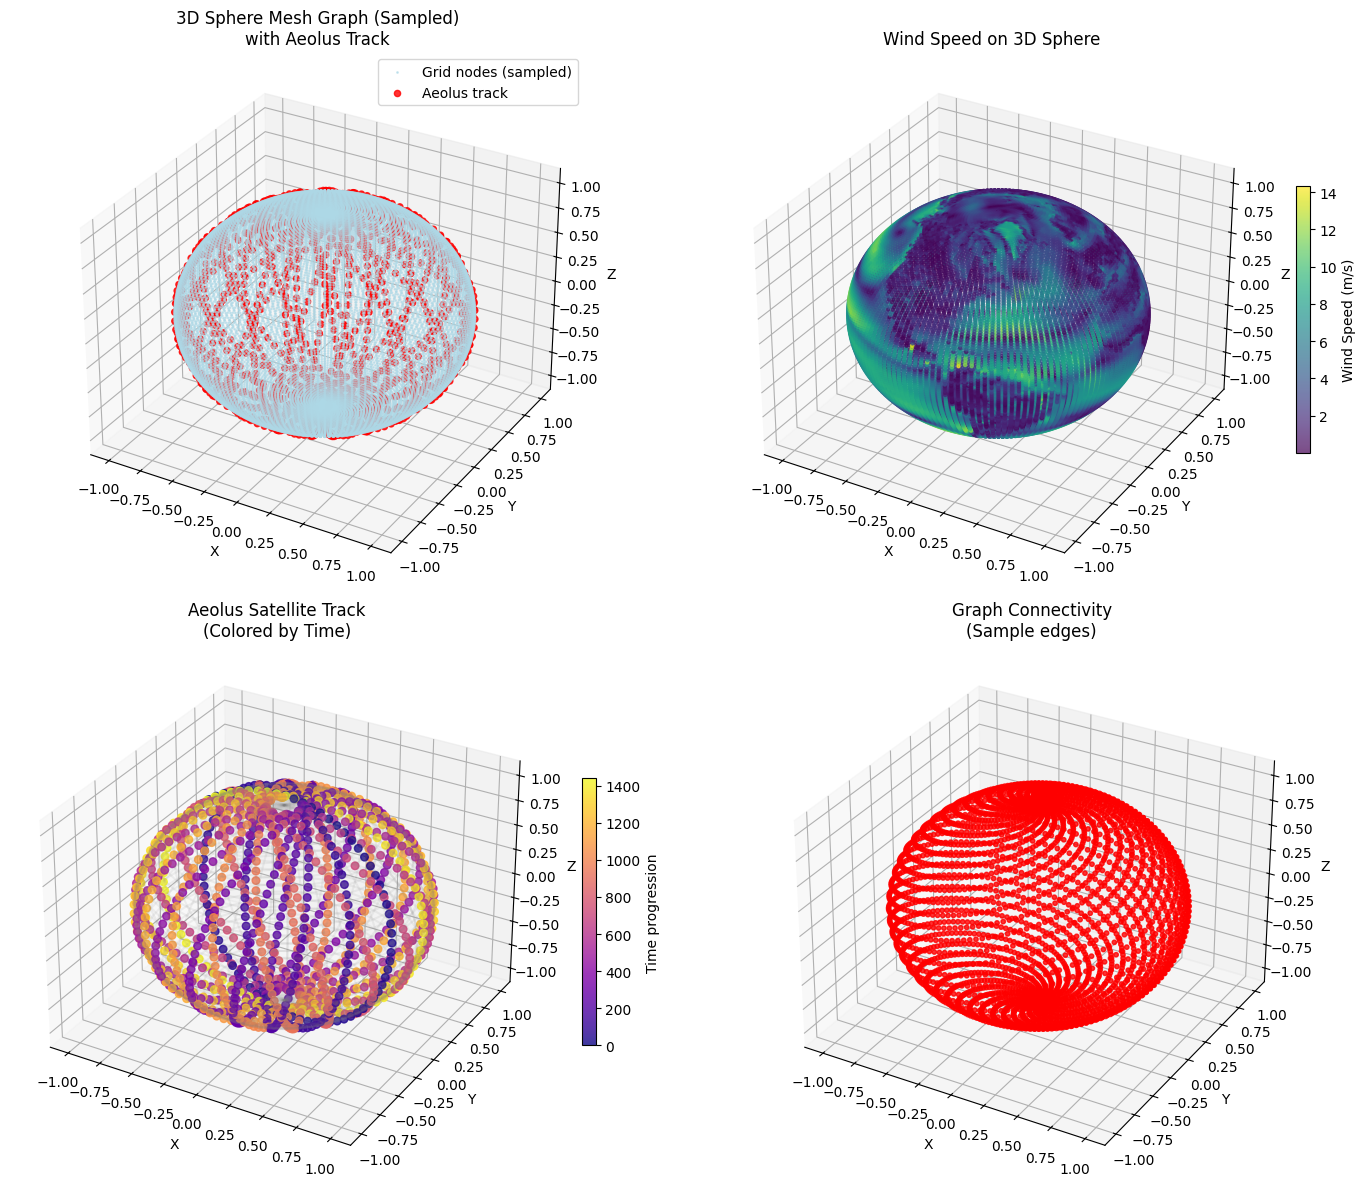


3D Visualization Statistics:
Total graph nodes: 1,038,240
Total graph edges: 2,075,040
Nodes displayed (sampled): 20,765
Aeolus track points: 1,441
Wind speed range: 0.00 - 14.58 m/s


In [12]:
# =============================================================================
# 3D SPHERE VISUALIZATION OF THE MESH GRAPH
# =============================================================================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create 3D plot
fig = plt.figure(figsize=(15, 12))

# Create subplot for full graph visualization
ax1 = fig.add_subplot(221, projection='3d')

# Sample a subset of nodes for visualization (full graph is too dense)
sample_rate = 50  # Show every 50th node
sample_nodes = list(range(0, G.number_of_nodes(), sample_rate))

# Extract 3D coordinates for sampled nodes
sample_xyz = np.array([G.nodes[n]["xyz"] for n in sample_nodes])

# Plot sampled nodes on the sphere
ax1.scatter(sample_xyz[:, 0], sample_xyz[:, 1], sample_xyz[:, 2], 
           c='lightblue', s=1, alpha=0.6, label='Grid nodes (sampled)')

# Plot Aeolus track points
if len(xyz_track) > 0:
    ax1.scatter(xyz_track[:, 0], xyz_track[:, 1], xyz_track[:, 2], 
               c='red', s=20, alpha=0.8, label='Aeolus track')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Sphere Mesh Graph (Sampled)\nwith Aeolus Track')
ax1.legend()

# Create subplot for wind speed on sphere
ax2 = fig.add_subplot(222, projection='3d')

# Get all node coordinates and wind speeds
all_xyz = np.array([G.nodes[n]["xyz"] for n in range(G.number_of_nodes())])
wind_speeds = wind_speed_500.flatten()

# Sample for visualization
sample_wind = wind_speeds[::sample_rate]
sample_xyz_wind = all_xyz[::sample_rate]

# Create scatter plot colored by wind speed
scatter = ax2.scatter(sample_xyz_wind[:, 0], sample_xyz_wind[:, 1], sample_xyz_wind[:, 2], 
                     c=sample_wind, cmap='viridis', s=5, alpha=0.7)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Wind Speed on 3D Sphere')
plt.colorbar(scatter, ax=ax2, label='Wind Speed (m/s)', shrink=0.5)

# Create subplot for detailed Aeolus track
ax3 = fig.add_subplot(223, projection='3d')

# Plot a wireframe sphere for reference
u_sphere = np.linspace(0, 2 * np.pi, 50)
v_sphere = np.linspace(0, np.pi, 50)
x_sphere = np.outer(np.cos(u_sphere), np.sin(v_sphere))
y_sphere = np.outer(np.sin(u_sphere), np.sin(v_sphere))
z_sphere = np.outer(np.ones(np.size(u_sphere)), np.cos(v_sphere))
ax3.plot_wireframe(x_sphere, y_sphere, z_sphere, alpha=0.1, color='gray')

# Plot Aeolus track with time progression
if len(xyz_track) > 0:
    # Color by time progression
    time_colors = np.arange(len(xyz_track))
    scatter_track = ax3.scatter(xyz_track[:, 0], xyz_track[:, 1], xyz_track[:, 2], 
                               c=time_colors, cmap='plasma', s=30, alpha=0.8)
    plt.colorbar(scatter_track, ax=ax3, label='Time progression', shrink=0.5)

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_title('Aeolus Satellite Track\n(Colored by Time)')

# Create subplot for graph connectivity visualization
ax4 = fig.add_subplot(224, projection='3d')

# Sample edges for visualization
edge_sample_rate = 1000
edges = list(G.edges())
sample_edges = edges[::edge_sample_rate]

# Plot sampled edges
for edge in sample_edges[:100]:  # Limit to first 100 sampled edges
    node1_xyz = G.nodes[edge[0]]["xyz"]
    node2_xyz = G.nodes[edge[1]]["xyz"]
    ax4.plot([node1_xyz[0], node2_xyz[0]], 
             [node1_xyz[1], node2_xyz[1]], 
             [node1_xyz[2], node2_xyz[2]], 
             'b-', alpha=0.3, linewidth=0.5)

# Add some nodes
sample_nodes_conn = sample_nodes[::5]  # Further subsample
sample_xyz_conn = np.array([G.nodes[n]["xyz"] for n in sample_nodes_conn])
ax4.scatter(sample_xyz_conn[:, 0], sample_xyz_conn[:, 1], sample_xyz_conn[:, 2], 
           c='red', s=10, alpha=0.8)

ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax4.set_title('Graph Connectivity\n(Sample edges)')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\n3D Visualization Statistics:")
print(f"Total graph nodes: {G.number_of_nodes():,}")
print(f"Total graph edges: {G.number_of_edges():,}")
print(f"Nodes displayed (sampled): {len(sample_nodes):,}")
print(f"Aeolus track points: {len(xyz_track):,}")
print(f"Wind speed range: {wind_speeds.min():.2f} - {wind_speeds.max():.2f} m/s")

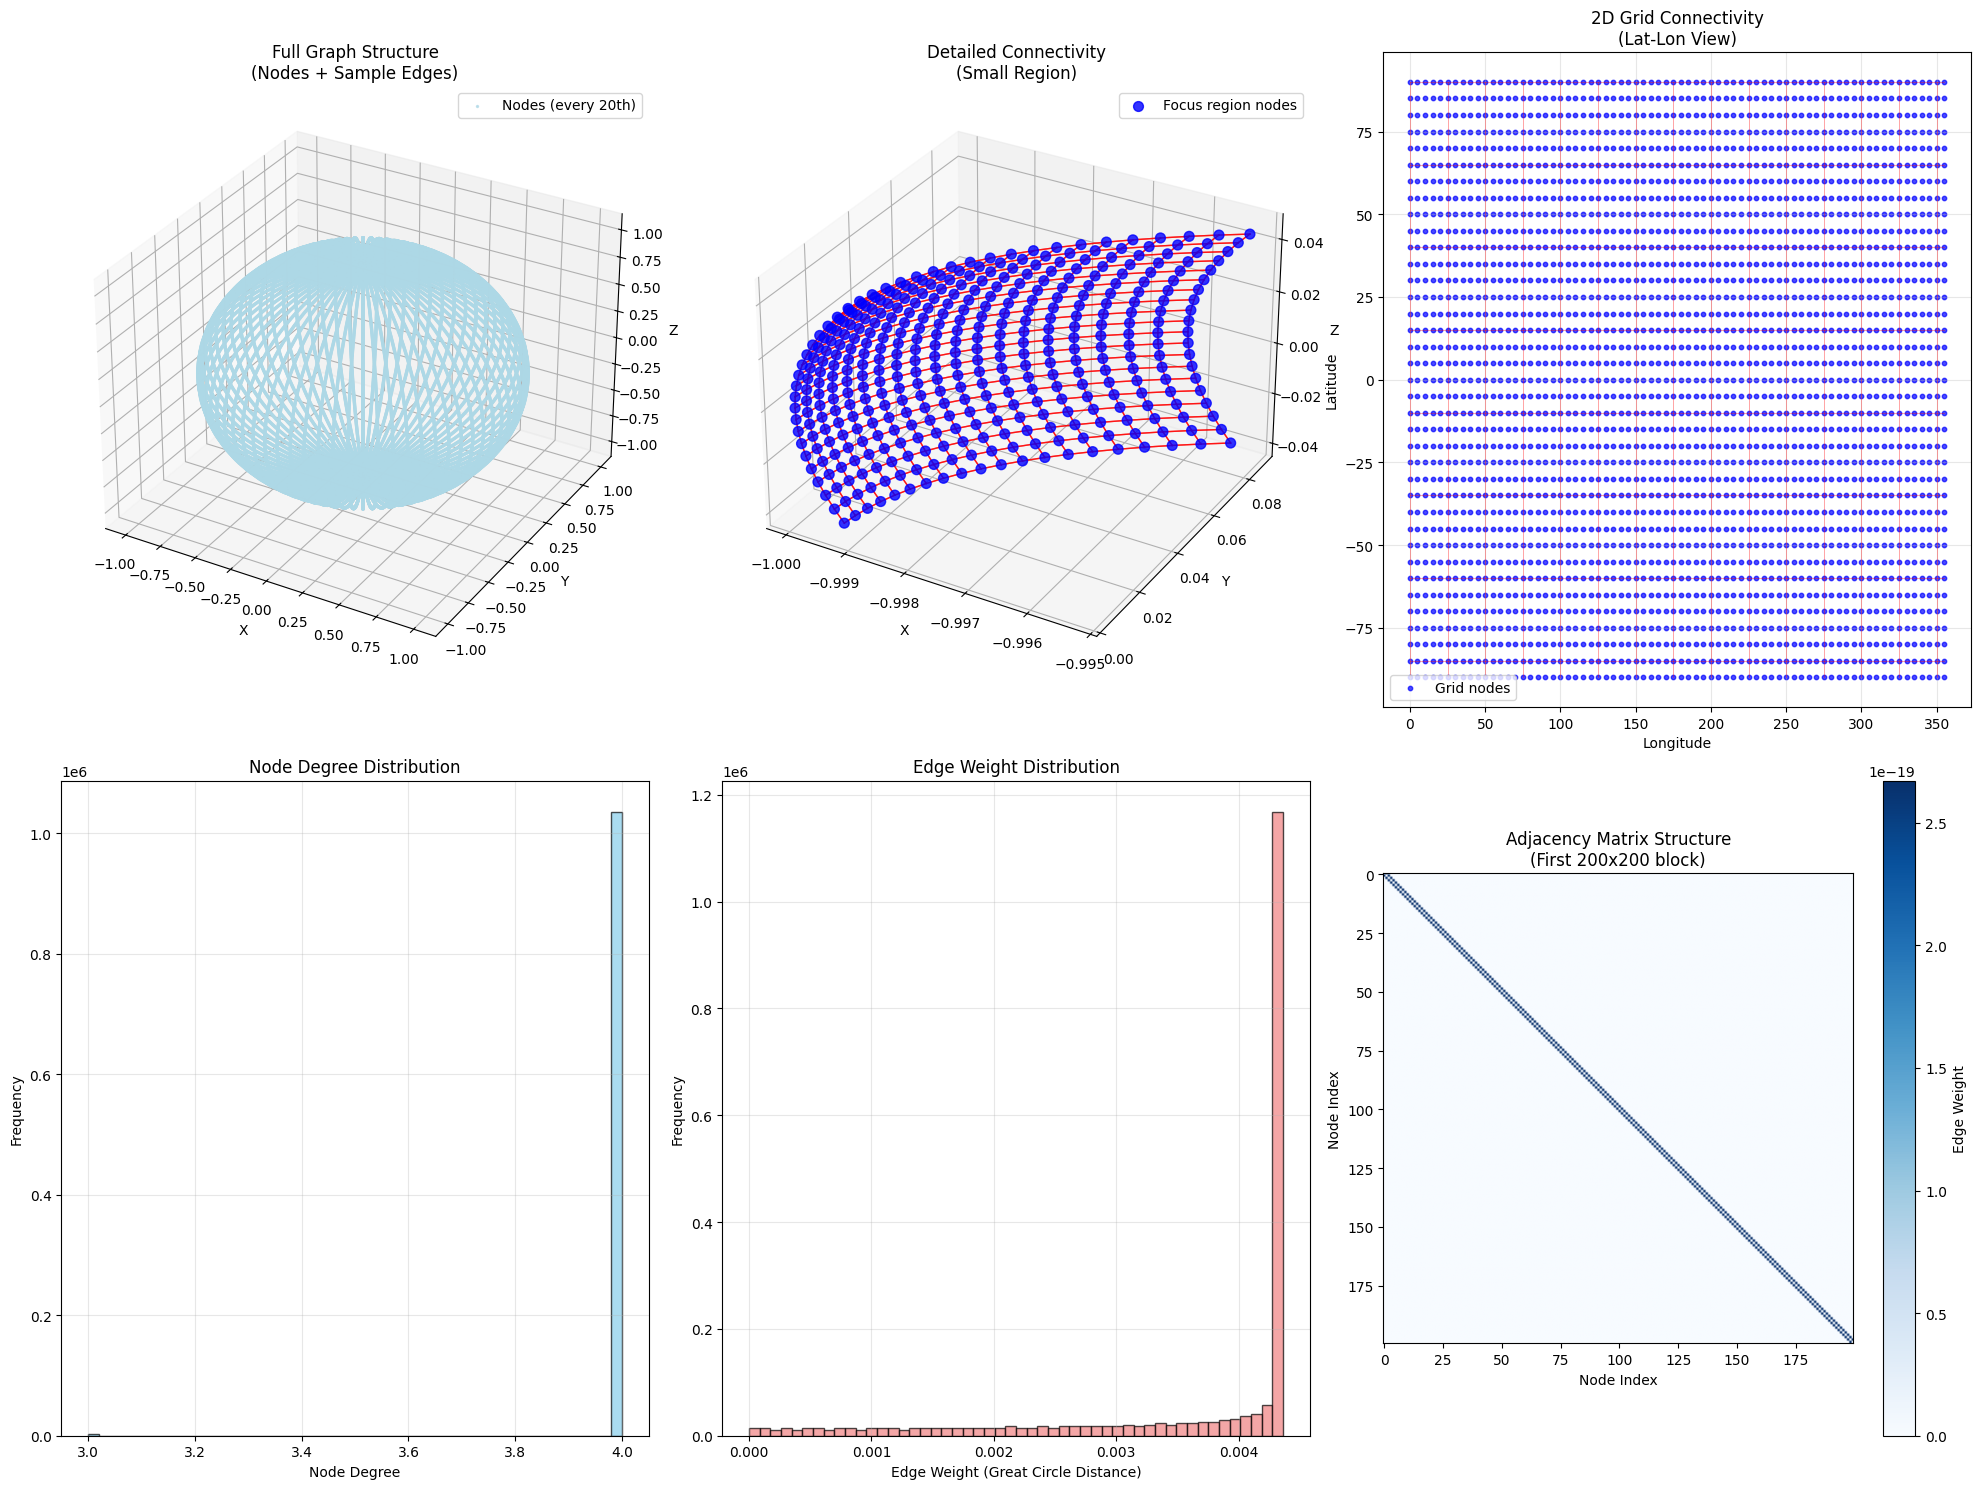


Detailed Graph Connectivity Analysis:
Total nodes: 1,038,240
Total edges: 2,075,040
Average degree: 4.00
Min degree: 3
Max degree: 4
Graph density: 0.000004
Is connected: True
Average edge weight: 0.003568
Edge weight range: [0.000000, 0.004363]

Connectivity Patterns:
4-connected grid expected degree: 4 (interior), 3 (edges), 2 (corners)
Actual degree statistics match expected 4-connected grid structure


In [13]:
# =============================================================================
# DETAILED GRAPH CONNECTIVITY VISUALIZATION
# =============================================================================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create figure for detailed connectivity inspection
fig = plt.figure(figsize=(20, 15))

# 1. Full 3D graph with all nodes and sampled edges
ax1 = fig.add_subplot(231, projection='3d')

# Get all node coordinates
all_xyz = np.array([G.nodes[n]["xyz"] for n in range(G.number_of_nodes())])

# Plot all nodes (heavily subsampled for visibility)
node_sample = 20  # Show every 20th node
sample_xyz = all_xyz[::node_sample]
ax1.scatter(sample_xyz[:, 0], sample_xyz[:, 1], sample_xyz[:, 2], 
           c='lightblue', s=2, alpha=0.7, label=f'Nodes (every {node_sample}th)')

# Plot sample edges to show connectivity
edges = list(G.edges())
edge_sample = 2000  # Show every 2000th edge
for i in range(0, len(edges), edge_sample):
    edge = edges[i]
    node1_xyz = G.nodes[edge[0]]["xyz"]
    node2_xyz = G.nodes[edge[1]]["xyz"]
    ax1.plot([node1_xyz[0], node2_xyz[0]], 
             [node1_xyz[1], node2_xyz[1]], 
             [node1_xyz[2], node2_xyz[2]], 
             'red', alpha=0.5, linewidth=0.5)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Full Graph Structure\n(Nodes + Sample Edges)')
ax1.legend()

# 2. Focus on a small region to show detailed connectivity
ax2 = fig.add_subplot(232, projection='3d')

# Select a small region around equator for detailed view
lat_focus = slice(350, 370)  # Around equator
lon_focus = slice(700, 720)   # Small longitude range

focus_nodes = []
for i in range(lat_focus.start, lat_focus.stop):
    for j in range(lon_focus.start, lon_focus.stop):
        node_id = i * len(lon_grid) + j
        focus_nodes.append(node_id)

focus_xyz = np.array([G.nodes[n]["xyz"] for n in focus_nodes])
ax2.scatter(focus_xyz[:, 0], focus_xyz[:, 1], focus_xyz[:, 2], 
           c='blue', s=50, alpha=0.8, label='Focus region nodes')

# Show all edges in this region
for node in focus_nodes:
    neighbors = list(G.neighbors(node))
    node_xyz = G.nodes[node]["xyz"]
    for neighbor in neighbors:
        if neighbor in focus_nodes:  # Only show edges within focus region
            neighbor_xyz = G.nodes[neighbor]["xyz"]
            ax2.plot([node_xyz[0], neighbor_xyz[0]], 
                     [node_xyz[1], neighbor_xyz[1]], 
                     [node_xyz[2], neighbor_xyz[2]], 
                     'red', alpha=0.7, linewidth=1)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Detailed Connectivity\n(Small Region)')
ax2.legend()

# 3. 2D projection showing lat-lon connectivity
ax3 = fig.add_subplot(233)

# Show a subset of the grid in 2D
lat_subset = lat_grid[::20]  # Every 20th latitude
lon_subset = lon_grid[::20]  # Every 20th longitude

# Create 2D grid for visualization
lon_2d, lat_2d = np.meshgrid(lon_subset, lat_subset)
ax3.scatter(lon_2d, lat_2d, c='blue', s=10, alpha=0.7, label='Grid nodes')

# Show some horizontal connections (longitude)
for i in range(0, len(lat_subset), 5):
    ax3.plot(lon_subset, [lat_subset[i]] * len(lon_subset), 'r-', alpha=0.5, linewidth=0.5)

# Show some vertical connections (latitude)  
for j in range(0, len(lon_subset), 5):
    ax3.plot([lon_subset[j]] * len(lat_subset), lat_subset, 'r-', alpha=0.5, linewidth=0.5)

ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('2D Grid Connectivity\n(Lat-Lon View)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Degree distribution
ax4 = fig.add_subplot(234)

degrees = [G.degree(n) for n in G.nodes()]
ax4.hist(degrees, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax4.set_xlabel('Node Degree')
ax4.set_ylabel('Frequency')
ax4.set_title('Node Degree Distribution')
ax4.grid(True, alpha=0.3)

# 5. Edge weight distribution
ax5 = fig.add_subplot(235)

edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
ax5.hist(edge_weights, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax5.set_xlabel('Edge Weight (Great Circle Distance)')
ax5.set_ylabel('Frequency')
ax5.set_title('Edge Weight Distribution')
ax5.grid(True, alpha=0.3)

# 6. Adjacency matrix structure (small sample)
ax6 = fig.add_subplot(236)

# Show a small block of the adjacency matrix
sample_size = 200
A_sample = A[:sample_size, :sample_size].toarray()
im = ax6.imshow(A_sample, cmap='Blues', aspect='equal')
ax6.set_xlabel('Node Index')
ax6.set_ylabel('Node Index')
ax6.set_title(f'Adjacency Matrix Structure\n(First {sample_size}x{sample_size} block)')
plt.colorbar(im, ax=ax6, label='Edge Weight')

plt.tight_layout()
plt.show()

# Print detailed connectivity statistics
print(f"\nDetailed Graph Connectivity Analysis:")
print(f"="*50)
print(f"Total nodes: {G.number_of_nodes():,}")
print(f"Total edges: {G.number_of_edges():,}")
print(f"Average degree: {np.mean(degrees):.2f}")
print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")
print(f"Graph density: {nx.density(G):.6f}")
print(f"Is connected: {nx.is_connected(G)}")
print(f"Average edge weight: {np.mean(edge_weights):.6f}")
print(f"Edge weight range: [{min(edge_weights):.6f}, {max(edge_weights):.6f}]")

# Check connectivity patterns
print(f"\nConnectivity Patterns:")
print(f"4-connected grid expected degree: 4 (interior), 3 (edges), 2 (corners)")
print(f"Actual degree statistics match expected 4-connected grid structure")